In [220]:
import numpy as np
import matplotlib.pyplot as plt
import AtmosphericBlocking
import h5py
import sys, glob
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

In [204]:
alpha=0.55
tau = 10*86400.0

In [205]:
def gaussforce(x,t,peak=2,inject=True):
    tc = 277.8
    tw = 2.5
    t = t/86400.0
    xc = 16800.0e3
    xw = 2800.0e3
    sx = 1.*1.852e-5 + np.zeros(len(x))
    if inject:
        sx *= (1+peak*np.exp(-((x-xc)/xw)**2 - ((t-tc)/tw)**2))
    return sx

In [206]:
def noforce(x,t,peak=None,inject=None):
    sx = np.zeros(len(x))
    return sx

In [207]:
def xtsinforce(x,t,peak=None,inject=None):
    sx = 2.0e-5 + 2.0e-5*np.sin(2*np.pi*x/x[-1]-np.pi/6.0)*np.sin(2*np.pi*t/(4.0*86400.0))
    return sx

In [208]:
def xsinforce(x,t,peak=None,inject=None):
    sx = 2.0e-5 + 2.0e-5*np.sin(2*np.pi*x/x[-1]-np.pi/6.0)
    return sx

In [209]:
def noboru_cx(x,Lx,alpha):
    A0 = 10*(1-np.cos(1*4*np.pi*x/Lx))
    cx = 60 - 2*alpha*A0
    return cx,A0

In [210]:
model = AtmosphericBlocking.Model(nx=2048,Lx = 28000e3,dt=.001*86400,alpha=alpha,
                                        tmax=3.5*86400,D=3.26e5,tau=tau,
                                        sfunc=gaussforce,cfunc=noboru_cx,
                                        forcingpeak=2,injection=True,
                                        save_to_disk=True,
                                        overwrite=True,
                                        tsave_snapshots=200,
                                        path = 'outputnew/')

## run the model

In [211]:
model.tmax = 320*86400
model.run()

## get output

### setup file

In [304]:
setup = h5py.File("outputnew/setup.h5")
x = setup['grid/x'][:]

### merge snapshots

In [305]:
fnis = np.array(sorted(glob.glob("outputnew/snapshots/*.h5")))

In [329]:
Ahat, F = 0,0
t = []
for fni in fnis[1200::2]:
    snap = h5py.File(fni)
    t.append(snap['t'][()])
    try:
        Ahat = np.vstack([Ahat, snap['A'][:]])
        F = np.vstack([F, snap['F'][:]])
    except:
        Ahat = snap['A'][:]
        F = snap['F'][:]

t = np.array(t)

In [330]:
Gamma = 4*model.alpha*F/(model.C[np.newaxis])**2

## animate fields

In [331]:
def gaussforce_array(x,t,peak=2,inject=True):
    tc = 277.8
    tw = 2.5
    t = t/86400.0
    xc = 16800.0e3
    xw = 2800.0e3
    sx = 1.*1.852e-5 + np.zeros((len(t),len(x)))
    if inject:
        sx *= (1+peak*np.exp(-((x-xc)/xw)**2 - ((t-tc)/tw)**2))
    return sx

In [332]:
S = gaussforce_array(model.x,t[:,np.newaxis],peak=2,inject=True)

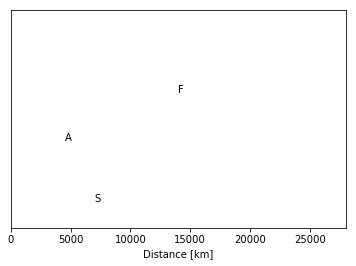

In [345]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, model.x.max()/1e3))
ax.set_ylim((0, 100))

ax.set_yticks([])
ax.set_xlabel(r"Distance [km]")

ax.text(7000,12,"S")
ax.text(4500,40,"A")
ax.text(14000,62,"F")



line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)

In [346]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return (line,)

In [347]:
# animation function. This is called sequentially
def animate(i):
    x = model.x/1e3
    line.set_data(x, Ahat[i]+model.A0[np.newaxis])
    line2.set_data(x, F[i]/10)
    line3.set_data(x, S[i]*1e6)
    return (line,)

In [348]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=t.size, interval=75, blit=True)

In [349]:
HTML(anim.to_html5_video())

In [351]:
anim.save('1d_fields.mp4')

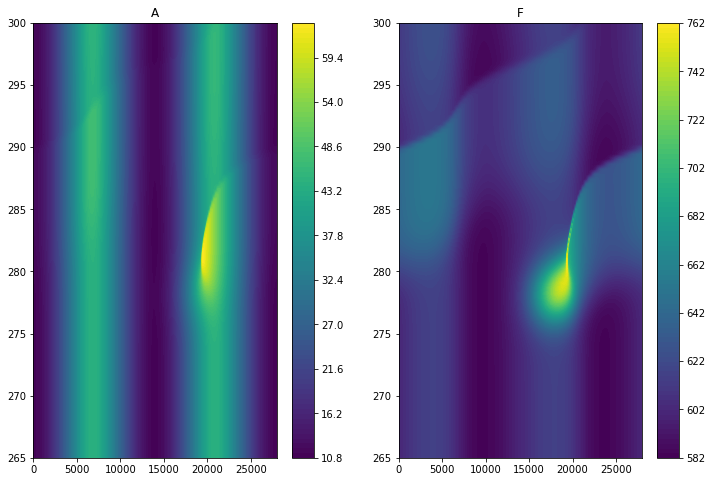

In [215]:
plt.figure(figsize=(12.,8))
plt.subplot(121)
plt.contourf(x/1e3,t/86400,Ahat+model.A0[np.newaxis,:],100,shading='Gouraud')
plt.ylim(265,300)
plt.colorbar()
plt.title("A")

plt.subplot(122)
plt.contourf(x/1e3,t/86400,F,100)
plt.ylim(265,300)
plt.colorbar()
plt.title("F")

(15000, 28000)

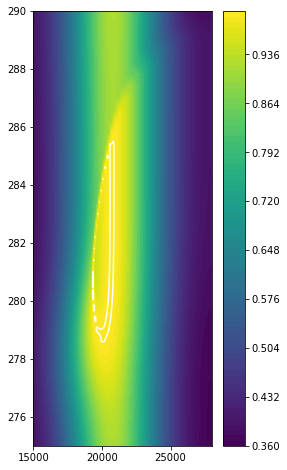

In [201]:
plt.figure(figsize=(4.,8))

plt.contourf(x/1e3,t/86400,Gamma,100,shading='Gouraud')
plt.colorbar()


plt.contour(x/1e3,t/86400,Gamma,[.999, 1.],colors='w')
plt.ylim(275,290)
plt.xlim(15000,28000)



In [202]:
Gamma.max()

0.99999999976232312